In [19]:
"""
Environment setup
Purpose:
  Only lightweight, widely-used libraries
  required for local LLM inference, retrieval and
  evaluation. No cloud services or external APIs.
"""
!pip install -q torch transformers accelerate sentence-transformers pypdf matplotlib

In [20]:
import os

for d in ["data", "analysis"]:
    os.makedirs(d, exist_ok=True)

In [21]:
"""
Document loader

Purpose:
- Simulate private personal knowledge (notes, PDFs)
- No preprocessing beyond text extraction
- Privacy preserved: all data is local
"""
from pypdf import PdfReader

def load_documents(folder="data"):
    docs = []
    for file in os.listdir(folder):
        path = os.path.join(folder, file)

        if file.endswith(".txt"):
            with open(path, "r", encoding="utf-8") as f:
                docs.append(f.read())

        elif file.endswith(".pdf"):
            reader = PdfReader(path)
            text = " ".join(
                page.extract_text() for page in reader.pages
                if page.extract_text() is not None
            )
            docs.append(text)

    return docs

In [22]:
documents = load_documents()
print(f"Loaded {len(documents)} documents")

Loaded 3 documents


In [24]:
"""
Chunking module
- On-device LLMs have limited context
- Chunking allows retrieval-based context selection

Design:
- chunk_size = 400 tokens → semantic completeness
- overlap = 50 tokens → boundary robustness
"""

def chunk_text(text, chunk_size=400, overlap=50):
    words = text.split()
    chunks = []
    i = 0

    while i < len(words):
        chunk = words[i:i + chunk_size]
        chunks.append(" ".join(chunk))
        i += chunk_size - overlap

    return chunks

In [7]:
documents = load_documents()

all_chunks = []
for doc in documents:
    all_chunks.extend(chunk_text(doc))

print(f"Total chunks created: {len(all_chunks)}")

Total chunks created: 55


In [26]:
"""
Local retrieval module
- Select only relevant chunks
- Reduce hallucinations
- Reduce latency

Privacy:
- No vector DB
- No external services
"""

from sentence_transformers import SentenceTransformer
import torch

embedder = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2"
)

chunk_embeddings = embedder.encode(
    all_chunks,
    convert_to_tensor=True,
    show_progress_bar=True
)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
def retrieve_chunks(query, k=4):
    query_emb = embedder.encode(query, convert_to_tensor=True)
    scores = torch.cosine_similarity(query_emb, chunk_embeddings)
    topk = torch.topk(scores, k).indices
    return [all_chunks[i] for i in topk]

In [28]:
"""
Qwen2.5-3B-Instruct
- Instruction-tuned → clean summaries
- Strong technical summarization
- Stable generation
- Suitable for edge / on-device scenarios
"""

from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16,
    device_map="auto"
)

model.eval()

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), eps=1e-06)
    (ro

In [39]:
"""
Summarization pipeline
- Instruction-friendly prompt
- Deterministic decoding (no sampling)
- Decode ONLY newly generated tokens
"""

def clean_summary(text):

    if "<END>" in text:
        text = text.split("<END>")[0]

    stop_markers = [
        "\nHuman:",
        "\nAssistant:",
        "\nCertainly!",
        "\nResume",
        "\nHere is",
        "\nExample"
    ]

    for marker in stop_markers:
        if marker in text:
            text = text.split(marker)[0]

    return text.strip()


def summarize(query, k=4, max_tokens=180):
    """
    End-to-end PocketMind summarization pipeline.

    Steps:
    1. Retrieve top-k relevant chunks
    2. Build a single-shot summarization prompt
    3. Generate deterministically
    4. Decode ONLY newly generated tokens
    5. Clean any conversational spillover
    """

    retrieved = retrieve_chunks(query, k=k)
    context = "\n\n".join(retrieved)

    prompt = (
        "Task: Write a concise summary in 5–6 sentences.\n"
        "Rules:\n"
        "- Output ONLY the summary\n"
        "- Do not include examples, resumes, explanations, or follow-up text\n"
        "- Stop immediately when the summary is complete\n"
        "- End the output with the token <END>\n\n"
        "Document:\n"
        f"{context}\n\n"
        "Summary:\n"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    prompt_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False,
            temperature=0.2,
            repetition_penalty=1.15,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode ONLY the newly generated tokens
    generated_tokens = output[0][prompt_len:]
    summary = tokenizer.decode(
        generated_tokens,
        skip_special_tokens=True
    )

    # Hard stop cleanup
    summary = clean_summary(summary)

    return summary, retrieved

In [40]:
query = ("Summarize the main contributions, methodology, and results of the paper on generative pre-training for language understanding.")

summary, retrieved_chunks = summarize(query)

print("SUMMARY : \n")
print(summary)

SUMMARY : 

The paper presents a novel approach to enhance natural language understanding by training a language model on a diverse corpus of unlabeled text before fine-tuning it for specific tasks like question answering, semantic similarity assessment, entailment determination, and text classification. This method achieves significant improvements over traditional discriminative training techniques, demonstrating better performance on nine out of twelve evaluated datasets. Key aspects include leveraging the Transformer architecture's inductive biases for various tasks and incorporating auxiliary language modeling objectives during fine-tuning.


In [41]:
"""
Latency measurement

Measures end-to-end summarization time.
Simulates on-device responsiveness.
"""

import time

start = time.time()
_ = summarize(query)
latency = time.time() - start

print(f"Latency: {latency:.2f} seconds")

Latency: 14.57 seconds


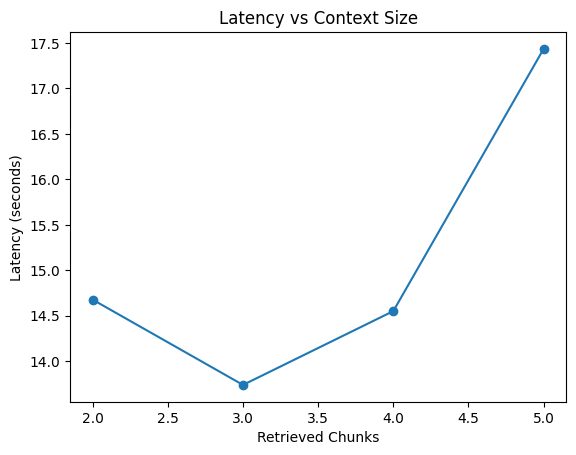

In [42]:
"""
Latency vs number of retrieved chunks
"""

import matplotlib.pyplot as plt

context_sizes = [2, 3, 4, 5]
latencies = []

for k in context_sizes:
    start = time.time()
    _ = summarize(query, k=k)
    latencies.append(time.time() - start)

plt.figure()
plt.plot(context_sizes, latencies, marker="o")
plt.xlabel("Retrieved Chunks")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs Context Size")
plt.show()

In [44]:
"""
Faithfulness metric (heuristic)

Purpose:
- Estimate how much of the summary is grounded
- Not perfect, but useful for trend analysis
"""

def hallucination_rate(summary, source_chunks):
    supported = 0
    for chunk in source_chunks:
        if any(word in summary.lower() for word in chunk.lower().split()[:30]):
            supported += 1
    return 1 - supported / max(1, len(source_chunks))

In [45]:
rate = hallucination_rate(summary, retrieved_chunks)
print(f"Hallucination rate (lower is better): {rate:.2f}")

Hallucination rate (lower is better): 0.00


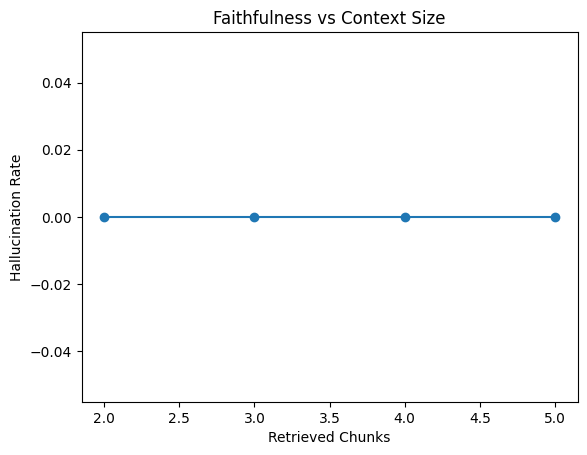

In [46]:
"""
Faithfulness vs context size
"""

rates = []

for k in context_sizes:
    summary, retrieved = summarize(query, k=k)
    rates.append(hallucination_rate(summary, retrieved))

plt.figure()
plt.plot(context_sizes, rates, marker="o")
plt.xlabel("Retrieved Chunks")
plt.ylabel("Hallucination Rate")
plt.title("Faithfulness vs Context Size")
plt.show()